In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import cv2

ModuleNotFoundError: No module named 'cv2'

In [2]:
# find the data
data_files = os.listdir('../data')
glue_control_files = [file for file in data_files if 'glue_control' in file]
assert len(glue_control_files) == 1, 'More than one glue control file found'
glue_control_file = glue_control_files[0]
# check if its a json file, if so, read it in
if glue_control_file.endswith('.json'):
    glue_control_file = json.load(open('../data/' + glue_control_file))
    glue_control_dir = glue_control_file['dir']
    if len(glue_control_dir)>0:
        found = False
        # loop through the glue control dir options to find the one that exists
        for dir in glue_control_dir:
            if os.path.exists(dir):
                data_dir = "../processed_data/" + dir.split('/')[-2]
                if os.path.exists(data_dir):
                    found = True
                    print('Data directory: {}'.format(data_dir))
                    break
                else:
                    Exception('Data directory does not exist')
        if not found:
            Exception('Glue control directory does not exist')
else:
    Exception('Glue control file is not a json file')

Data directory: ../processed_data/Glue_Ctl_mixed_age_19Oct23_2023_10_19_17_10_46


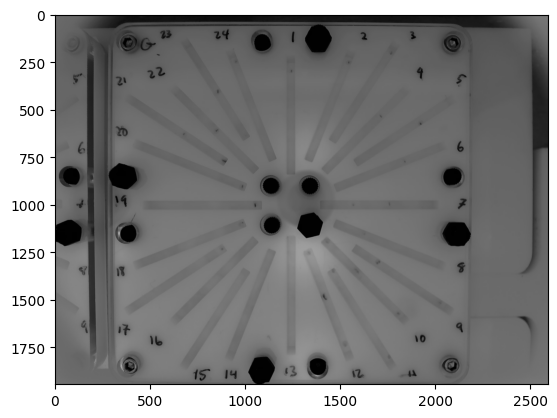

In [3]:
CAM_NO = 0
# get all the files in the data directory with the correct camera number
data_files = os.listdir(data_dir)
data_files = [file for file in data_files if 'cam{}'.format(CAM_NO) in file]
# make sure there is (1) merged.mp4 file (2) background.png file (3) background_endpoints.json file (4) background_pois.json file
assert 'cam{}_merged.mp4'.format(CAM_NO) in data_files, 'No merged.mp4 file found'
assert 'cam{}_background.png'.format(CAM_NO) in data_files, 'No background.png file found'
assert 'cam{}_background_endpoints.json'.format(CAM_NO) in data_files, 'No background_endpoints.json file found'
assert 'cam{}_background_pois.json'.format(CAM_NO) in data_files, 'No background_pois.json file found'
# get the background image
background = cv2.imread(data_dir + '/cam{}_background.png'.format(CAM_NO))
background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
# show the background image
plt.imshow(background)

In [84]:
# get the background masks
background_endpoints = json.load(open(data_dir + '/cam{}_background_endpoints.json'.format(CAM_NO)))
background_pois = json.load(open(data_dir + '/cam{}_background_pois.json'.format(CAM_NO)))
background_masks = json.load(open(data_dir + '/cam{}_background_masks.json'.format(CAM_NO)))
background_masks = np.array([background_masks[key] for key in background_masks.keys()])

In [9]:
# get the video
cap = cv2.VideoCapture(data_dir + '/cam{}_merged.mp4'.format(CAM_NO))
# get the number of frames
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# get 100 random frames
random_frames = np.random.randint(0, n_frames, 100)
# loop through the frames
background_differences = []
for i in tqdm(random_frames):
    cap.set(cv2.CAP_PROP_POS_FRAMES, i)
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # get the background difference
    background_difference = (frame.mean(axis=2)- background.mean(axis=2)).flatten()
    background_differences.append(background_difference)
# convert to numpy array
background_differences = np.array(background_differences).flatten()

  0%|          | 0/100 [00:00<?, ?it/s]

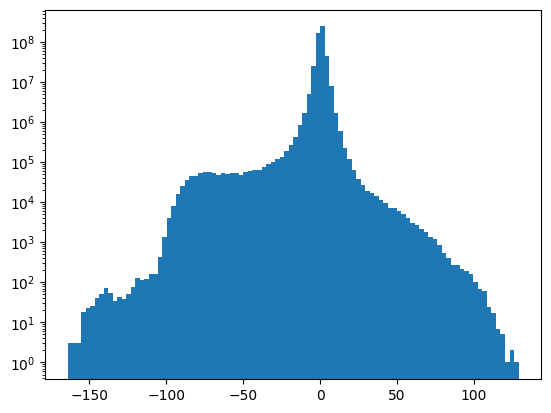

In [10]:
# plot the background differences histogram
plt.hist(background_differences, bins=100)
plt.yscale('log')
plt.show()

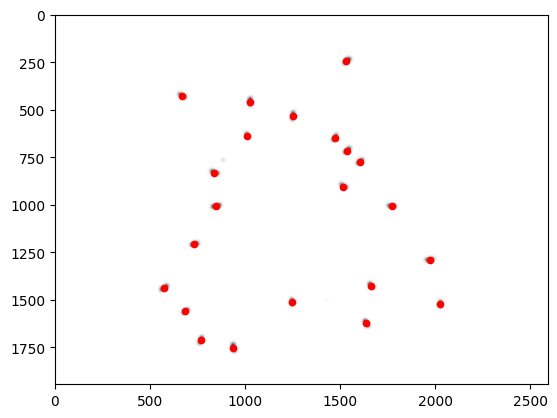

In [71]:
only_ants = ((frame.mean(axis=2)- background.mean(axis=2))>-50).astype(np.uint8)
only_ants = np.array([only_ants, only_ants, only_ants]).transpose(1,2,0)*255
# convert to grayscale
only_ants = cv2.cvtColor(only_ants, cv2.COLOR_BGR2GRAY)
# flip using bitwise not
# only_ants = cv2.bitwise_not(only_ants)
# apply a gaussian blur
only_ants = cv2.GaussianBlur(only_ants, (55,55), 0)
# show the image
plt.imshow(only_ants, cmap='gray')

# apply a blob detector
detector = cv2.SimpleBlobDetector_create()
keypoints = detector.detect(only_ants)
# convert to numpy array
keypoints = np.array([[kp.pt[0], kp.pt[1]] for kp in keypoints])
# plot the keypoints 
plt.imshow(only_ants, cmap='gray')
plt.scatter(keypoints[:,0], keypoints[:,1], s=20, c='r')
plt.show()


In [72]:
# time the function
%timeit get_ant_locations(frame, background)

511 ms ± 9.83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [86]:
N_ARENAS = background_masks.shape[0]
pos = np.ones((N_ARENAS, 2))*np.nan
for i in keypoints:
    x,y = int(i[0]), int(i[1])
    arena_id = background_masks[:,y,x].argmax()
    pos[arena_id] = [i[0], i[1]]

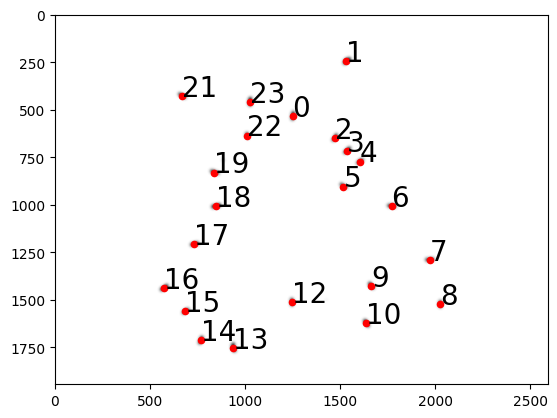

In [88]:
# plot the keypoints for each arena and number them
plt.imshow(only_ants, cmap='gray')
for i in range(N_ARENAS):
    if np.isnan(pos[i,0]) or np.isnan(pos[i,1]):
        continue
    plt.scatter(pos[i,0], pos[i,1], s=20, c='r')
    plt.text(pos[i,0], pos[i,1], str(i), fontsize=20)


In [44]:
background_masks

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

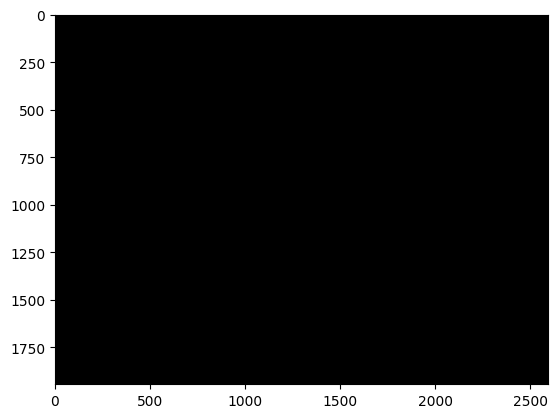

In [50]:
plt.imshow(background_masks.all(axis=0), cmap='gray')

In [54]:
background_masks.sum(axis=0).max()

255

In [4]:
CAM_NOs = list(set([int(x.split('_')[0][3:]) for x in os.listdir(data_dir) if x.startswith('cam')]))

In [1]:
import time
from joblib import Parallel, delayed
import os

# make a function that combines the entire process given a frame and a background
def get_ant_locations(frame, background, background_masks, N_ARENAS):
    # get the only ant mask
    only_ants = ((frame.mean(axis=2)- background.mean(axis=2))>-50).astype(np.uint8)
    only_ants = np.array([only_ants, only_ants, only_ants]).transpose(1,2,0)*255
    # convert to grayscale
    only_ants = cv2.cvtColor(only_ants, cv2.COLOR_BGR2GRAY)
    # apply a gaussian blur
    only_ants = cv2.GaussianBlur(only_ants, (55,55), 0)
    # apply a blob detector
    detector = cv2.SimpleBlobDetector_create()
    keypoints = detector.detect(only_ants)
    # convert to numpy array and get the positions and areas
    keypoints = np.array([[kp.pt[0], kp.pt[1], kp.size] for kp in keypoints])
    pos = np.ones((N_ARENAS, 2))*np.nan
    arena_sizes = np.zeros(N_ARENAS)
    for i in keypoints:
        x,y = int(i[0]), int(i[1])
        arena_vals = background_masks[:,y,x]
        # make sure not all the values are 0
        if arena_vals.sum()==0:
            continue
        # check if there are multiple arenas
        if arena_vals.sum()>255:
            continue
        arena_id = arena_vals.argmax()
        # check if the new keypoint is larger than the previous one
        if i[2]>arena_sizes[arena_id]:
            arena_sizes[arena_id] = i[2]
            pos[arena_id] = [i[0], i[1]]
        else:
            continue

    return pos

# make a function that processes the frames
def process_frames(video_file, frames, background, background_masks, N_ARENAS, verbose=True):
    positions = []
    frame_no = []
    if verbose:
        start_time = time.time()
    # open the video
    cap = cv2.VideoCapture(video_file)
    # load the video into memory
    start_frame = frames[0]
    end_frame = frames[-1]
    skip_frames = frames[1]-frames[0]
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    COUNT = 0
    for n,i in enumerate(range(end_frame-start_frame)):
        if skip_frames>1 and n%skip_frames!=0:
            continue
        ret, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        positions.append(get_ant_locations(frame, background, background_masks, N_ARENAS))
        frame_no.append(start_frame+n)
        COUNT += 1
        if verbose and COUNT%100==0:
            print('Processed {}/{}, Time elapsed: {:.2f}s'.format(COUNT, len(frames), time.time()-start_time))
    return positions, frame_no


All Camera and Metadata files found
Loading background image


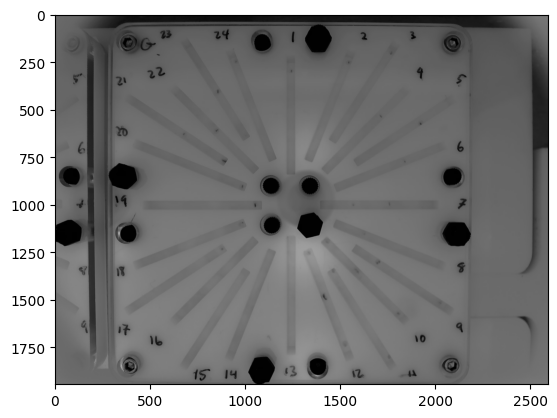

Loading background masks


In [26]:

CAM_NO = 0
# get all the files in the data directory with the correct camera number
data_files = os.listdir(data_dir)
data_files = [file for file in data_files if 'cam{}'.format(CAM_NO) in file]
# make sure there is (1) merged.mp4 file (2) background.png file (3) background_endpoints.json file (4) background_pois.json file
assert 'cam{}_merged.mp4'.format(CAM_NO) in data_files, 'No merged.mp4 file found'
assert 'cam{}_background.png'.format(CAM_NO) in data_files, 'No background.png file found'
assert 'cam{}_background_endpoints.json'.format(CAM_NO) in data_files, 'No background_endpoints.json file found'
assert 'cam{}_background_pois.json'.format(CAM_NO) in data_files, 'No background_pois.json file found'
print('All Camera and Metadata files found')
# get the background image
print('Loading background image')
background = cv2.imread(data_dir + '/cam{}_background.png'.format(CAM_NO))
background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
# show the background image
plt.imshow(background)
plt.show()
# get the background masks
print('Loading background masks')
background_endpoints = json.load(open(data_dir + '/cam{}_background_endpoints.json'.format(CAM_NO)))
background_pois = json.load(open(data_dir + '/cam{}_background_pois.json'.format(CAM_NO)))
background_masks = json.load(open(data_dir + '/cam{}_background_masks.json'.format(CAM_NO)))
background_masks = np.array([background_masks[key] for key in background_masks.keys()])
N_ARENAS = background_masks.shape[0]

In [7]:
# load the video to set up the frames
print('Loading video')
cap = cv2.VideoCapture(data_dir + '/cam{}_merged.mp4'.format(CAM_NO))
n_threads = os.cpu_count()//2 
skip_frames = 10
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
n_frames_per_thread = int(np.ceil(n_frames/n_threads))
frames_per_thread = [np.arange(i*n_frames_per_thread, (i+1)*n_frames_per_thread, skip_frames) for i in range(n_threads)]
cap.release()

# run the function in parallel
print('Running function in parallel with {} threads'.format(n_threads))
positions = Parallel(n_jobs=n_threads)(delayed(process_frames)(data_dir + '/cam{}_merged.mp4'.format(CAM_NO), frames, background, background_masks, N_ARENAS) for frames in frames_per_thread)

Loading video
Running function in parallel with 4 threads
Processed 100/2250, Time elapsed: 39.17s
Processed 100/2250, Time elapsed: 39.81s
Processed 100/2250, Time elapsed: 39.94s
Processed 100/2250, Time elapsed: 41.07s
Processed 200/2250, Time elapsed: 74.99s
Processed 200/2250, Time elapsed: 75.66s
Processed 200/2250, Time elapsed: 75.75s
Processed 200/2250, Time elapsed: 76.97s
Processed 300/2250, Time elapsed: 112.17s
Processed 300/2250, Time elapsed: 113.53s
Processed 300/2250, Time elapsed: 113.71s
Processed 300/2250, Time elapsed: 114.64s
Processed 400/2250, Time elapsed: 149.45s
Processed 400/2250, Time elapsed: 150.51s
Processed 400/2250, Time elapsed: 150.77s
Processed 400/2250, Time elapsed: 151.44s
Processed 500/2250, Time elapsed: 186.59s
Processed 500/2250, Time elapsed: 186.72s
Processed 500/2250, Time elapsed: 187.99s
Processed 500/2250, Time elapsed: 188.90s
Processed 600/2250, Time elapsed: 223.77s
Processed 600/2250, Time elapsed: 224.65s
Processed 600/2250, Time e

In [8]:
pos = np.concatenate([positions[i][0] for i in range(len(positions))])
t = np.array([positions[i][1] for i in range(len(positions))]).flatten()

In [9]:
# fill nan values in a array with linear interpolation of the last valid value and the next valid value
def fillna(x):
    # find the first valid value
    first_valid = np.where(~np.isnan(x))[0][0]
    # fill the nan values before the first valid value with the first valid value
    x[:first_valid] = x[first_valid]
    # find the last valid value
    last_valid = np.where(~np.isnan(x))[0][-1]
    # fill the nan values after the last valid value with the last valid value
    x[last_valid:] = x[last_valid]
    # loop through the array, when you find a nan value, find the next valid value and the previous valid value
    # then linearly interpolate between the two
    i = first_valid + 1
    while i<last_valid:
        if np.isnan(x[i]):
            # get the next valid value
            next_valid = np.where(~np.isnan(x[i:]))[0][0] + i
            # get the previous valid value
            prev_valid = np.where(~np.isnan(x[:i]))[0][-1]
            # fill the nan value with the linear interpolation
            x[i:next_valid] = np.linspace(x[prev_valid], x[next_valid], next_valid-prev_valid+1)[1:-1]
            # set i to the next valid value
            i = next_valid+1
        else:
            i += 1
    # make sure there are no nan values
    if np.isnan(x).sum()>0:
        print('There are still nan values')
        print(x)
    return x

In [10]:
for i in range(pos.shape[1]):
    pos[:,i,0] = fillna(pos[:,i,0])
    pos[:,i,1] = fillna(pos[:,i,1])

In [11]:
import pandas as pd

In [12]:
columns = ['frame', 'arena', 'x', 'y']
data = np.zeros((pos.shape[0]*pos.shape[1], pos.shape[2]+2))    
data[:,0] = np.repeat(t, pos.shape[1])
data[:,1] = np.tile(np.arange(pos.shape[1]), pos.shape[0])
data[:,2:] = pos.reshape(-1, pos.shape[2])
data = pd.DataFrame(data, columns=columns)
data.to_csv(data_dir + '/cam{}_ant_locations.csv'.format(CAM_NO), index=False)

In [233]:
data

,frame,arena,x,y
0,0.0,0.0,1211.881104,721.529358
1,0.0,1.0,1377.579956,579.569153
2,0.0,2.0,1535.140625,513.205200
3,0.0,3.0,1429.855469,774.285278
4,0.0,4.0,1617.546631,727.838745
...,...,...,...,...
215899,89980.0,19.0,971.238220,888.682556
215900,89980.0,20.0,865.611267,760.092163
215901,89980.0,21.0,654.836914,420.978760
215902,89980.0,22.0,695.621521,173.662811


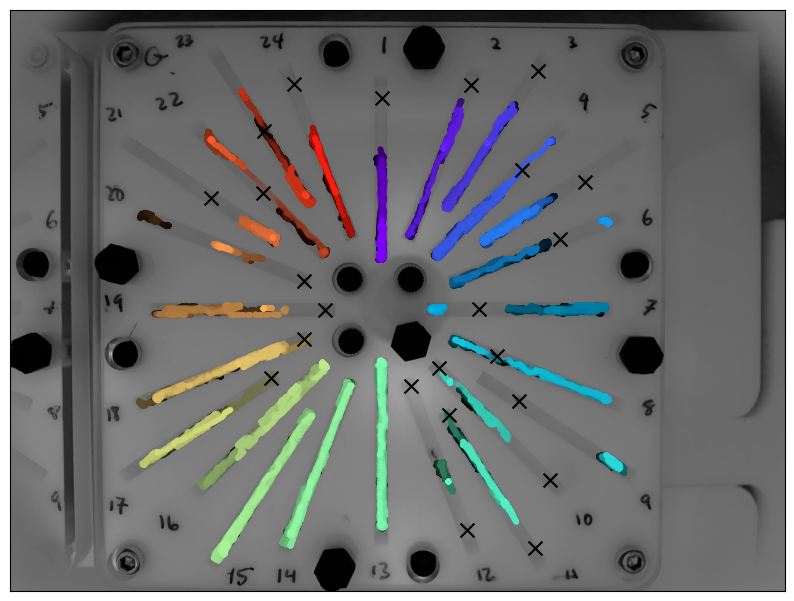

In [27]:
# define a function that creates a linear smooth colormap from black to a color
from matplotlib.colors import ListedColormap
def make_cmap(color):
    # get the color RGB values
    r,g,b,_ = color
    # create a linear gradient from black to the color
    cmap = np.array([np.linspace(0,r,256), np.linspace(0,g,256), np.linspace(0,b,256)]).T
    return ListedColormap(cmap)

fig, ax = plt.subplots(1,1,figsize=(10,10))
# show the background image
plt.imshow(background)
for arena_id in range(N_ARENAS):
    plt.scatter(pos[:,arena_id,0], pos[:,arena_id,1], s=10, c=t, cmap=make_cmap(plt.cm.rainbow(arena_id/N_ARENAS)), alpha=0.3)
    # plot the POIs
    pois = np.array(background_pois["arena_{}_original".format(arena_id+1)])
    for i in range(pois.shape[0]):
        plt.scatter(pois[i,0], pois[i,1], s=100, c='k', marker='x')
# hide the axes
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.savefig(data_dir + '/cam{}_ant_locations.png'.format(CAM_NO), bbox_inches='tight', pad_inches=0)
plt.show()


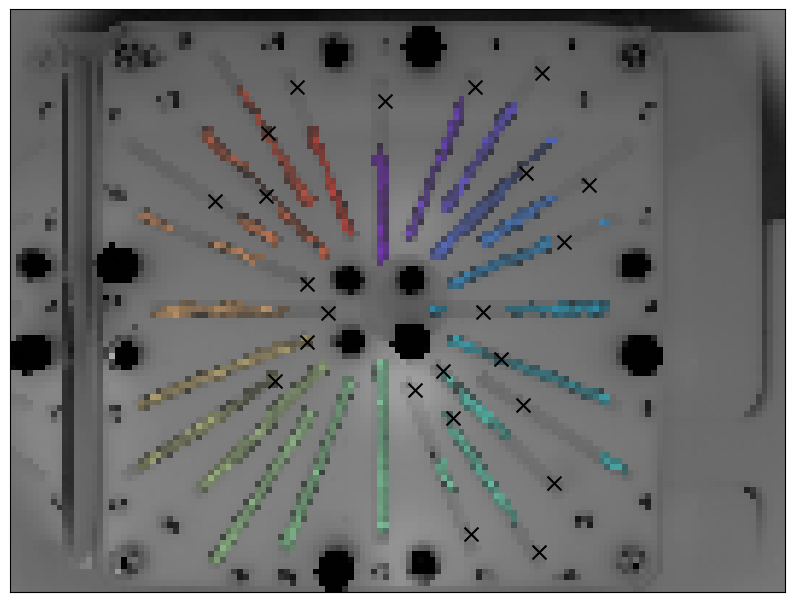

In [28]:
# make a 2d histogram plot
fig, ax = plt.subplots(1,1,figsize=(10,10))
# show the background image
n_bins = 100
background_small = cv2.resize(background, (int(n_bins*background.shape[1]/background.shape[0]), n_bins))
plt.imshow(background_small)
for arena_id in range(N_ARENAS):
    # get the positions for the arena
    x = pos[:,arena_id,0]
    y = pos[:,arena_id,1]
    # create the 2d histogram

    H, xedges, yedges = np.histogram2d(y, x, bins=(n_bins,int(n_bins*background.shape[1]/background.shape[0])),range=[[0, background.shape[0]], [0, background.shape[1]]])
    # log transform the histogram
    H = np.log(H+1)
    # plot the 2d histogram (make 0 values transparent)

    masked_array = np.ma.masked_where(H == 0, H)
    plt.imshow(masked_array, cmap=make_cmap(plt.cm.rainbow(arena_id/N_ARENAS)), interpolation='nearest', vmin=0, vmax=H[H>0].max(), alpha=0.5)
    # plot the POIs
    pois = np.array(background_pois["arena_{}_original".format(arena_id+1)])
    for i in range(pois.shape[0]):
        plt.scatter(pois[i,0]*n_bins/background.shape[0], pois[i,1]*n_bins/background.shape[0], s=100, c='k', marker='x')
# hide the axes
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.savefig(data_dir + '/cam{}_ant_locations_2dhist.png'.format(CAM_NO), bbox_inches='tight', pad_inches=0)
plt.show()

angle in degrees: 112.33169205209103
perpendicular angle in degrees: 202.33169205209106
x_offset: -23.1249922006643
y_offset: -9.499196582828223


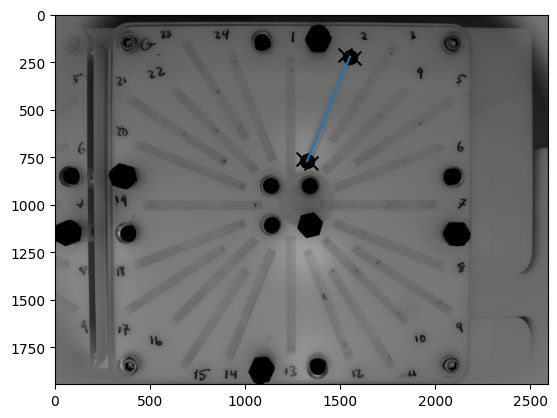

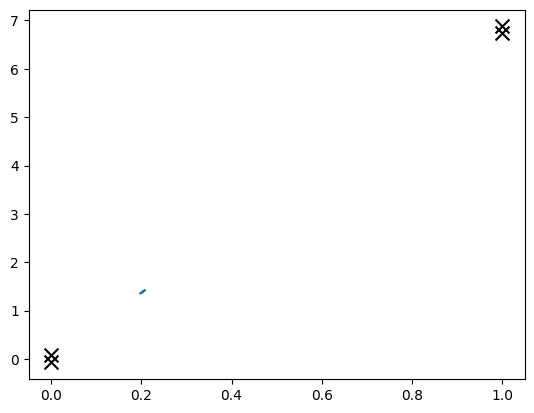

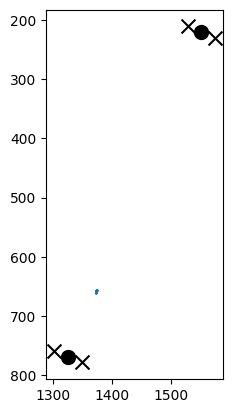

In [25]:
def transform(point, endpoints, width):
    # convert to numpy array
    point = np.array(point)
    # if point is 1d, convert to 2d
    if len(point.shape)==1:
        point = point.reshape(1,-1)
        single_point = True
    else:
        single_point = False
    point1 = endpoints[0] # each point is a tuple of (x,y)
    point2 = endpoints[1] # each point is a tuple of (x,y)
    # get the angle of the line from point2 to point1
    angle = np.arctan2(point1[1]-point2[1], point1[0]-point2[0])
    # get the distance between point1 and point2
    distance = np.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)
    # recentre the point wrt point2
    # point = (point[0]-point2[0], point[1]-point2[1])
    # point = np.array((point[:,0]-point2[0], point[:,1]-point2[1])).T
    point[:,0] = point[:,0]-point2[0]
    point[:,1] = point[:,1]-point2[1]
    # rotate the point by the negative angle
    # point = (point[0]*np.cos(-angle)-point[1]*np.sin(-angle), point[0]*np.sin(-angle)+point[1]*np.cos(-angle))
    point[:,0] = point[:,0]*np.cos(-angle)-point[:,1]*np.sin(-angle)
    point[:,1] = point[:,0]*np.sin(-angle)+point[:,1]*np.cos(-angle)
    # scale the x coordinate by the distance and y coordinate by the width
    # point = (point[0]/distance, point[1]/width)
    point[:,0] = point[:,0]/distance
    point[:,1] = point[:,1]/width
    # return the point
    if single_point:
        return point[0]
    else:
        return point

arena_id = 1
duration = 1000
start = 1000
end = start+duration

plt.imshow(background)
point1 = background_endpoints[f'arena_{arena_id+1}_original'][0]
point2 = background_endpoints[f'arena_{arena_id+1}_original'][1]
# plot the endpoints and the line joining them
plt.scatter(point1[0], point1[1], s=100, c='k', marker='o')
plt.scatter(point2[0], point2[1], s=100, c='k', marker='o')
plt.plot([point1[0], point2[0]], [point1[1], point2[1]], '-')
angle = np.arctan2(point2[1]-point1[1], point2[0]-point1[0])
print("angle in degrees: {}".format(angle*180/np.pi))
perp_angle = angle + np.pi/2
print("perpendicular angle in degrees: {}".format(perp_angle*180/np.pi))
width = 50
x_offset = width/2*np.cos(perp_angle)
y_offset = width/2*np.sin(perp_angle)
print("x_offset: {}".format(x_offset))
print("y_offset: {}".format(y_offset))
c1 = (point1[0]+x_offset, point1[1]+y_offset)
c2 = (point1[0]-x_offset, point1[1]-y_offset)
c3 = (point2[0]+x_offset, point2[1]+y_offset)
c4 = (point2[0]-x_offset, point2[1]-y_offset)
# plot the corners
plt.scatter(c1[0], c1[1], s=100, c='k', marker='x')
plt.scatter(c2[0], c2[1], s=100, c='k', marker='x')
plt.scatter(c3[0], c3[1], s=100, c='k', marker='x')
plt.scatter(c4[0], c4[1], s=100, c='k', marker='x')
plt.show()


points = []
for i in range(start,end):
    points.append(transform(pos[i,arena_id,:],background_endpoints[f'arena_{arena_id+1}_original'], width))
points = np.array(points)
plt.plot(points[:,0], points[:,1], '-')
for p in [c1,c2,c3,c4]:
    p_ = transform(p,background_endpoints[f'arena_{arena_id+1}_original'], width)
    plt.scatter(p_[0], p_[1], s=100, c='k', marker='x')
plt.show()
plt.plot(pos[start:end,arena_id,0], pos[start:end,arena_id,1], '-')
for p in background_endpoints[f'arena_{arena_id+1}_original']:
    plt.scatter(p[0], p[1], s=100, c='k', marker='o')
for p in [c1,c2,c3,c4]:
    plt.scatter(p[0], p[1], s=100, c='k', marker='x')
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [274]:
transform_v(pos[start:end,arena_id,:], endpoints=background_endpoints[f'arena_{arena_id+1}_original'], width=width)

ValueError: wrong number of outputs from pyfunc: expected 1, got 2